# GNN Training for Aftershock Prediction (Binary Classification)

**Course:** SE4050 - Deep Learning  
**Assignment:** Deep Learning Project  

## Objective
Train and compare 4 Graph Neural Network architectures for **aftershock triggering prediction** (binary classification):
1. **GCN** - Graph Convolutional Network (baseline)
2. **GAT** - Graph Attention Network (attention-based)
3. **GraphSAGE** - Sampling and aggregation
4. **Temporal GNN** - GCN + LSTM hybrid (spatiotemporal)

## Task Definition
**Binary Classification**: Predict whether an earthquake will trigger at least one aftershock within:
- **7 days** after the event
- **50 km** radius from the event

## Why This Task Works Better Than Magnitude Prediction

### Magnitude Prediction (Previous Task):
- ❌ **Severe class imbalance**: 82% of earthquakes are M 3.5-4.0
- ❌ **Low prediction variance**: Models predict constant values near mean
- ❌ **Poor R² scores**: ~0.01 (explaining only 1% of variance)
- ❌ **Graph structure not relevant**: Magnitude is determined by fault mechanics, not spatial proximity

### Aftershock Prediction (New Task):
- ✅ **Balanced classes**: ~46% vs ~54% (much better than 82% vs 18%)
- ✅ **Graph structure is meaningful**: Aftershocks cluster spatially and temporally
- ✅ **Physically relevant**: Stress transfer between earthquakes is a real phenomenon
- ✅ **Scientifically important**: Aftershock forecasting has practical applications

## Dataset
- **Source:** USGS Earthquake Catalog (California, 1990-2024)
- **Nodes:** Individual earthquake events (5,727 total)
- **Edges:** Spatial (k-NN, k=10) + Temporal (6h window)
- **Features:** 28 engineered features per node
- **Target:** Binary (0=no aftershocks, 1=triggers aftershocks)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')

# Import models
from models.gnn import (
    EarthquakeGCN,
    EarthquakeGAT,
    EarthquakeGraphSAGE,
    TemporalEarthquakeGNN
)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Create directories
os.makedirs('../results/models/gnn_aftershock', exist_ok=True)
os.makedirs('../results/visualizations/gnn_aftershock', exist_ok=True)

print("\n✓ Setup complete")

Device: cpu
PyTorch version: 2.8.0+cpu

✓ Setup complete


## Load Earthquake Graph for Aftershock Prediction

The graph contains:
- **Node features:** 28 engineered features (spatial, temporal, seismic activity)
- **Edges:** k-NN spatial (k=10) + temporal sequences (6h window)
- **Target:** Binary labels (triggers aftershock or not)
- **Splits:** Pre-defined train/val/test masks (chronological order)

In [2]:
# First, run conversion script to create PyTorch Geometric format
!python ../scripts/convert_gnn_aftershock_data.py

CONVERTING AFTERSHOCK GNN DATA TO PYTORCH GEOMETRIC FORMAT

Loading data from: ../data/processed/model_ready/gnn_data_aftershock.npy
✓ Converted successfully!
  Nodes: 5727, Edges: 75554, Features: 28
  Train: 4008, Val: 859, Test: 860

VALIDATING PYTORCH GEOMETRIC GRAPH

📊 Graph Summary:
  Nodes: 5727
  Edges: 75554
  Node features: 28

🎯 Target Variable (Aftershock Triggering):
  Class 0 (no aftershock): 2637 (46.0%)
  Class 1 (triggers aftershock): 3090 (54.0%)

✂️ Data Splits:
  Train: 4008 nodes (70.0%)
    - Class 0: 1901, Class 1: 2107
  Val: 859 nodes (15.0%)
    - Class 0: 323, Class 1: 536
  Test: 860 nodes (15.0%)
    - Class 0: 413, Class 1: 447

✓ No NaN or Inf values detected
✓ All edge indices are valid

✓ VALIDATION COMPLETE - Graph is ready for training!

Saved to: ../data/processed/model_ready/earthquake_graph_aftershock.pt

✓ Conversion complete!


In [3]:
print("Loading earthquake graph for aftershock prediction...")
data = torch.load('../data/processed/model_ready/earthquake_graph_aftershock.pt', weights_only=False)

print(f"\nGraph Statistics:")
print(f"  Nodes: {data.num_nodes:,}")
print(f"  Edges: {data.num_edges:,}")
print(f"  Node features: {data.num_node_features}")
print(f"  Average degree: {data.num_edges / data.num_nodes:.2f}")

print(f"\nData Splits:")
print(f"  Train: {data.train_mask.sum().item():,} nodes ({data.train_mask.sum().item()/data.num_nodes*100:.1f}%)")
print(f"  Val:   {data.val_mask.sum().item():,} nodes ({data.val_mask.sum().item()/data.num_nodes*100:.1f}%)")
print(f"  Test:  {data.test_mask.sum().item():,} nodes ({data.test_mask.sum().item()/data.num_nodes*100:.1f}%)")

print(f"\nTarget Distribution (Aftershock Triggering):")
print(f"  Overall: {data.y.sum().item():,} positive ({data.y.float().mean()*100:.1f}%)")
print(f"  Train: {data.y[data.train_mask].sum().item():,} positive ({data.y[data.train_mask].float().mean()*100:.1f}%)")
print(f"  Val: {data.y[data.val_mask].sum().item():,} positive ({data.y[data.val_mask].float().mean()*100:.1f}%)")
print(f"  Test: {data.y[data.test_mask].sum().item():,} positive ({data.y[data.test_mask].float().mean()*100:.1f}%)")

print("\n✓ Data loaded successfully")

Loading earthquake graph for aftershock prediction...

Graph Statistics:
  Nodes: 5,727
  Edges: 75,554
  Node features: 28
  Average degree: 13.19

Data Splits:
  Train: 4,008 nodes (70.0%)
  Val:   859 nodes (15.0%)
  Test:  860 nodes (15.0%)

Target Distribution (Aftershock Triggering):
  Overall: 3,090 positive (54.0%)
  Train: 2,107 positive (52.6%)
  Val: 536 positive (62.4%)
  Test: 447 positive (52.0%)

✓ Data loaded successfully


## Training Functions for Binary Classification

Key differences from magnitude prediction:
- **Loss function**: Binary Cross-Entropy instead of MSE
- **Metrics**: Accuracy, Precision, Recall, F1, ROC-AUC instead of RMSE/MAE/R²
- **Output layer**: 2 classes (sigmoid + BCELoss or 2-node softmax)

In [4]:
def train_epoch(model, data, optimizer, criterion, device, class_weights=None):
    """Train for one epoch using node masks."""
    model.train()
    data = data.to(device)
    
    optimizer.zero_grad()
    out = model(data)
    
    # Binary classification loss
    if class_weights is not None:
        criterion.weight = class_weights.to(device)
    
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    return loss.item()


def evaluate(model, data, criterion, device, mask):
    """Evaluate model on specific node set with binary classification metrics."""
    model.eval()
    data = data.to(device)
    
    with torch.no_grad():
        out = model(data)
        logits = out[mask]
        targets = data.y[mask]
        
        # Loss
        loss = criterion(logits, targets).item()
        
        # Predictions (argmax for 2-class output)
        predictions = logits.argmax(dim=1).cpu().numpy()
        targets_np = targets.cpu().numpy()
        
        # Probabilities for ROC-AUC
        probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(targets_np, predictions)
    precision = precision_score(targets_np, predictions, zero_division=0)
    recall = recall_score(targets_np, predictions, zero_division=0)
    f1 = f1_score(targets_np, predictions, zero_division=0)
    
    try:
        roc_auc = roc_auc_score(targets_np, probs)
    except:
        roc_auc = 0.0
    
    return {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': predictions,
        'targets': targets_np,
        'probabilities': probs
    }


def train_model(model, data, num_epochs=150, lr=0.001, patience=20, model_name='Model', class_weights=None):
    """Complete training loop with early stopping for binary classification."""
    model = model.to(device)
    data = data.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-5
    )
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_roc_auc': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"\nTraining {model_name}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, data, optimizer, criterion, device, class_weights)
        val_metrics = evaluate(model, data, criterion, device, data.val_mask)
        scheduler.step(val_metrics['loss'])
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_metrics['loss'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_roc_auc'].append(val_metrics['roc_auc'])
        
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_metrics['loss']:.4f} | "
                  f"Acc: {val_metrics['accuracy']:.4f} | "
                  f"F1: {val_metrics['f1']:.4f} | "
                  f"ROC-AUC: {val_metrics['roc_auc']:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(best_model_state)
    print(f"Best validation loss: {best_val_loss:.4f}")
    print("-" * 60)
    
    return model, history


print("✓ Training functions defined")

✓ Training functions defined


## Model Initialization with Binary Classification Output

All models are modified to output 2 classes (no aftershock vs triggers aftershock).

In [5]:
# Calculate class weights for imbalanced classes (if needed)
pos_count = data.y[data.train_mask].sum().item()
neg_count = data.train_mask.sum().item() - pos_count
pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

print(f"Class distribution in training set:")
print(f"  Negative (no aftershock): {neg_count}")
print(f"  Positive (triggers aftershock): {pos_count}")
print(f"  Positive class weight: {pos_weight:.2f}")

# Optional: Use class weights if imbalance is severe
use_class_weights = False  # Set to True if needed
class_weights = torch.tensor([1.0, pos_weight]) if use_class_weights else None

models = {
    'GCN': EarthquakeGCN(
        num_features=data.num_node_features,
        hidden_dim=64,
        num_layers=2,
        dropout=0.2,
        output_dim=2  # ⭐ 2 classes for binary classification
    ),
    
    'GAT': EarthquakeGAT(
        num_features=data.num_node_features,
        hidden_dim=32,
        num_layers=2,
        heads=4,
        dropout=0.2,
        output_dim=2  # ⭐ 2 classes
    ),
    
    'GraphSAGE': EarthquakeGraphSAGE(
        num_features=data.num_node_features,
        hidden_dim=64,
        num_layers=2,
        dropout=0.2,
        output_dim=2  # ⭐ 2 classes
    ),
    
    'Temporal-GNN': TemporalEarthquakeGNN(
        num_features=data.num_node_features,
        hidden_dim=64,
        lstm_hidden=32,
        num_gnn_layers=2,
        sequence_length=5,
        dropout=0.2,
        output_dim=2  # ⭐ 2 classes
    )
}

print("\nModel Summary:")
print("=" * 60)
for name, model in models.items():
    num_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{name:15s} | Parameters: {num_params:,} (trainable: {trainable_params:,})")
print("=" * 60)

Class distribution in training set:
  Negative (no aftershock): 1901
  Positive (triggers aftershock): 2107
  Positive class weight: 0.90

Model Summary:
GCN             | Parameters: 12,578 (trainable: 12,578)
GAT             | Parameters: 41,954 (trainable: 41,954)
GraphSAGE       | Parameters: 20,770 (trainable: 20,770)
Temporal-GNN    | Parameters: 24,098 (trainable: 24,098)


## Train All Models

Training configuration:
- **Epochs:** 150 (with early stopping)
- **Learning rate:** 0.001
- **Weight decay:** 5e-5
- **Loss:** Cross-Entropy Loss
- **Metrics:** Accuracy, F1, ROC-AUC
- **Early stopping:** Patience of 20 epochs

In [6]:
trained_models = {}
histories = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print(f"{'='*60}")
    
    trained_model, history = train_model(
        model=model,
        data=data,
        num_epochs=150,
        lr=0.001,
        patience=20,
        model_name=name,
        class_weights=class_weights
    )
    
    trained_models[name] = trained_model
    histories[name] = history
    
    torch.save(trained_model.state_dict(), f'../results/models/gnn_aftershock/{name}_model.pt')
    print(f"✓ Model saved to ../results/models/gnn_aftershock/{name}_model.pt")

print("\n" + "="*60)
print("ALL MODELS TRAINED SUCCESSFULLY")
print("="*60)


Training GCN

Training GCN
------------------------------------------------------------
Epoch   1 | Train Loss: 0.7267 | Val Loss: 0.6433 | Acc: 0.6612 | F1: 0.7843 | ROC-AUC: 0.7710
Epoch  10 | Train Loss: 0.5944 | Val Loss: 0.4502 | Acc: 0.8196 | F1: 0.8497 | ROC-AUC: 0.9159
Epoch  20 | Train Loss: 0.5334 | Val Loss: 0.3703 | Acc: 0.8242 | F1: 0.8515 | ROC-AUC: 0.9128
Epoch  30 | Train Loss: 0.4938 | Val Loss: 0.3707 | Acc: 0.8324 | F1: 0.8585 | ROC-AUC: 0.8984
Epoch  40 | Train Loss: 0.4790 | Val Loss: 0.3704 | Acc: 0.8277 | F1: 0.8535 | ROC-AUC: 0.8908
Early stopping at epoch 44
Best validation loss: 0.3678
------------------------------------------------------------
✓ Model saved to ../results/models/gnn_aftershock/GCN_model.pt

Training GAT

Training GAT
------------------------------------------------------------
Epoch   1 | Train Loss: 0.6469 | Val Loss: 0.4303 | Acc: 0.8021 | F1: 0.8330 | ROC-AUC: 0.8908
Epoch  10 | Train Loss: 0.4915 | Val Loss: 0.3560 | Acc: 0.8312 | F1: 0.

## Test Set Evaluation

Evaluate all trained models using binary classification metrics.

In [7]:
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

test_results = {}
criterion = nn.CrossEntropyLoss()

for name, model in trained_models.items():
    results = evaluate(model, data, criterion, device, data.test_mask)
    test_results[name] = results
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {results['accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall:    {results['recall']:.4f}")
    print(f"  F1 Score:  {results['f1']:.4f}")
    print(f"  ROC-AUC:   {results['roc_auc']:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(results['targets'], results['predictions'])
    print(f"  Confusion Matrix:")
    print(f"    TN={cm[0,0]}, FP={cm[0,1]}")
    print(f"    FN={cm[1,0]}, TP={cm[1,1]}")

best_model = max(test_results.keys(), key=lambda k: test_results[k]['f1'])
print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model} (F1: {test_results[best_model]['f1']:.4f})")
print(f"{'='*70}")

# Save results
import pickle
with open('../results/models/gnn_aftershock/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

with open('../results/models/gnn_aftershock/histories.pkl', 'wb') as f:
    pickle.dump(histories, f)

print("\n✓ Results saved")


TEST SET EVALUATION

GCN:
  Accuracy:  0.6895
  Precision: 0.7744
  Recall:    0.5682
  F1 Score:  0.6555
  ROC-AUC:   0.7859
  Confusion Matrix:
    TN=339, FP=74
    FN=193, TP=254

GAT:
  Accuracy:  0.6965
  Precision: 0.8370
  Recall:    0.5168
  F1 Score:  0.6390
  ROC-AUC:   0.7954
  Confusion Matrix:
    TN=368, FP=45
    FN=216, TP=231

GraphSAGE:
  Accuracy:  0.6872
  Precision: 0.9009
  Recall:    0.4474
  F1 Score:  0.5979
  ROC-AUC:   0.8017
  Confusion Matrix:
    TN=391, FP=22
    FN=247, TP=200

Temporal-GNN:
  Accuracy:  0.6884
  Precision: 0.9202
  Recall:    0.4385
  F1 Score:  0.5939
  ROC-AUC:   0.8134
  Confusion Matrix:
    TN=396, FP=17
    FN=251, TP=196

BEST MODEL: GCN (F1: 0.6555)

✓ Results saved


## Results Visualization

Create comprehensive visualizations for binary classification results.

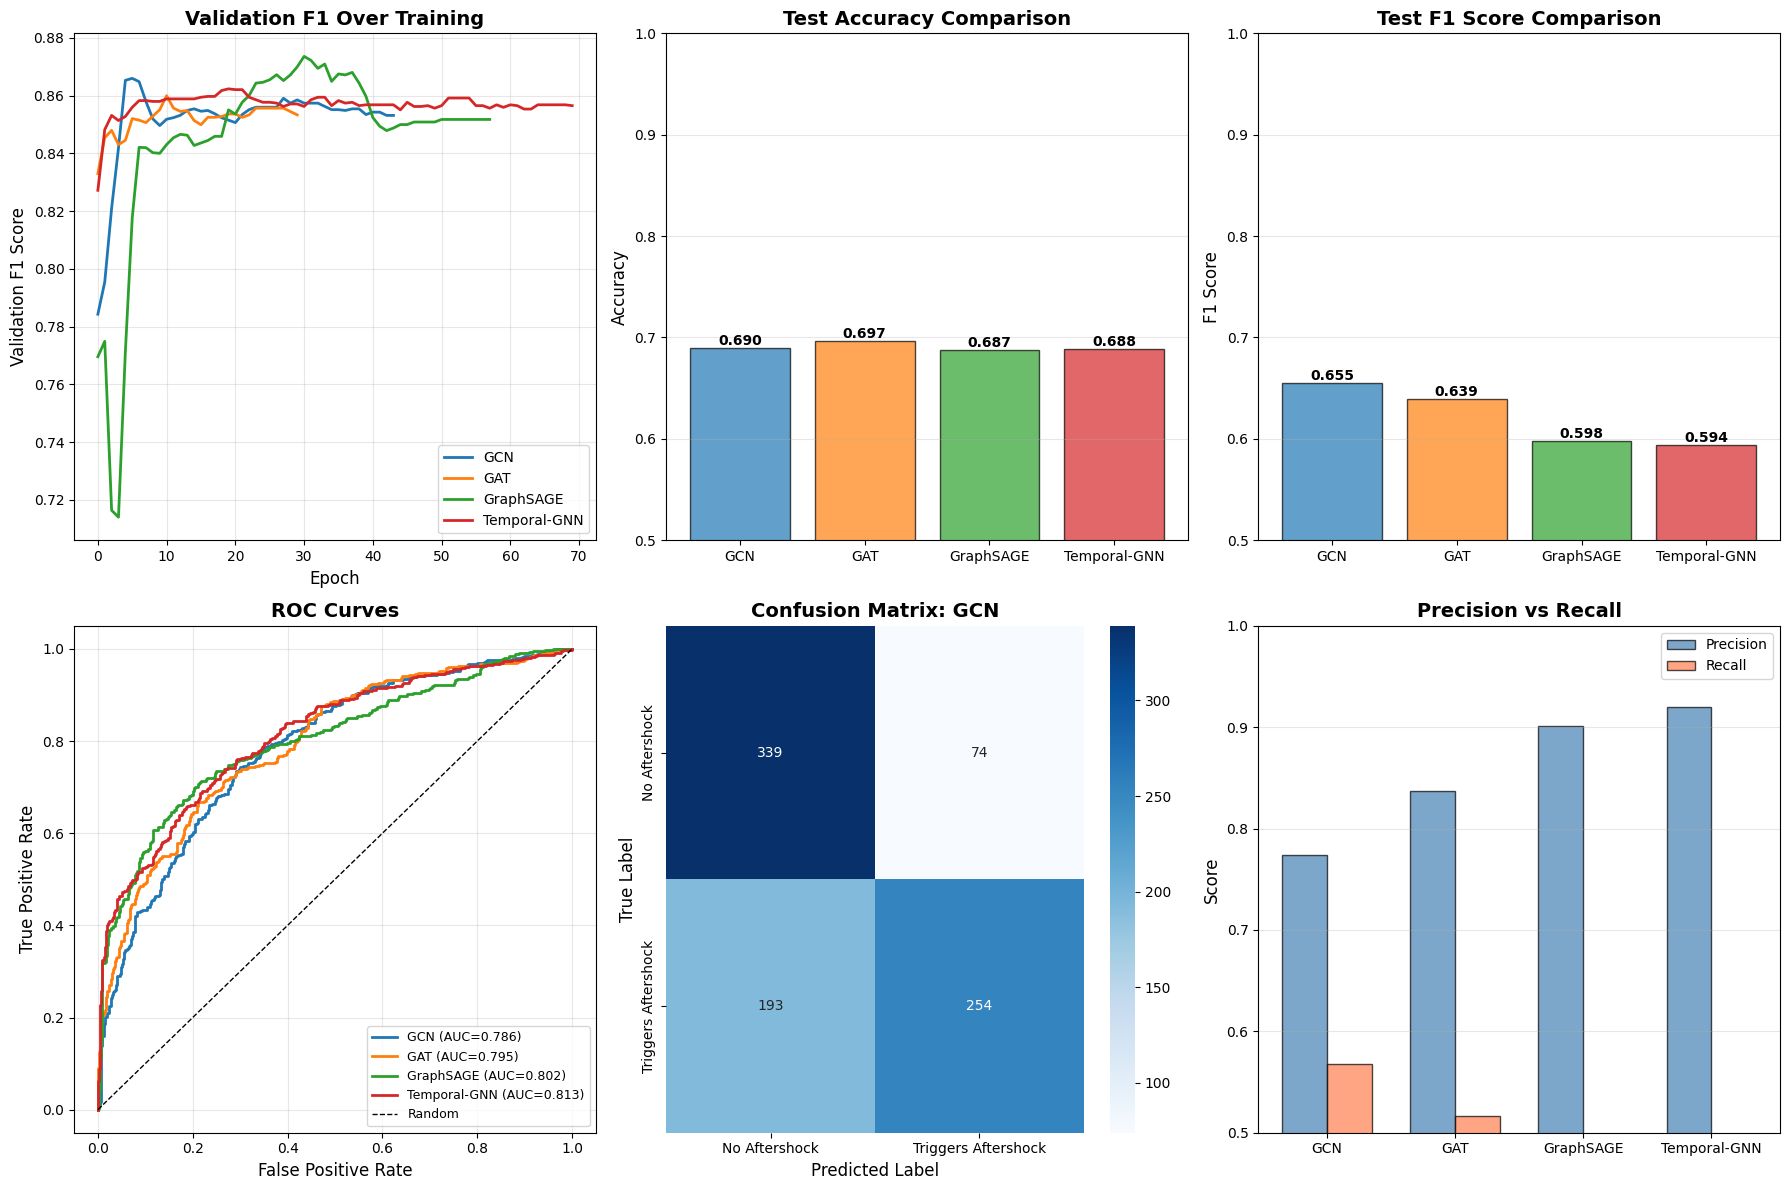


✓ Visualization saved to ../results/visualizations/gnn_aftershock/model_comparison.png


In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training curves (F1 score)
ax = axes[0, 0]
for name, color in zip(histories.keys(), ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']):
    ax.plot(histories[name]['val_f1'], label=name, linewidth=2, color=color)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation F1 Score', fontsize=12)
ax.set_title('Validation F1 Over Training', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Test Accuracy comparison
ax = axes[0, 1]
names = list(test_results.keys())
accuracy_values = [test_results[n]['accuracy'] for n in names]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(names, accuracy_values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0.5, 1.0])
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, accuracy_values):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.3f}', 
           ha='center', va='bottom', fontweight='bold')

# 3. F1 Score comparison
ax = axes[0, 2]
f1_values = [test_results[n]['f1'] for n in names]
bars = ax.bar(names, f1_values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Test F1 Score Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0.5, 1.0])
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, f1_values):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.3f}', 
           ha='center', va='bottom', fontweight='bold')

# 4. ROC curves
ax = axes[1, 0]
for name, color in zip(names, colors):
    fpr, tpr, _ = roc_curve(test_results[name]['targets'], test_results[name]['probabilities'])
    ax.plot(fpr, tpr, label=f"{name} (AUC={test_results[name]['roc_auc']:.3f})", 
           linewidth=2, color=color)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 5. Confusion matrix (best model)
ax = axes[1, 1]
best_model_name = max(test_results.keys(), key=lambda k: test_results[k]['f1'])
cm = confusion_matrix(test_results[best_model_name]['targets'], 
                     test_results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=True)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'Confusion Matrix: {best_model_name}', fontsize=14, fontweight='bold')
ax.set_xticklabels(['No Aftershock', 'Triggers Aftershock'])
ax.set_yticklabels(['No Aftershock', 'Triggers Aftershock'])

# 6. Precision-Recall comparison
ax = axes[1, 2]
precision_values = [test_results[n]['precision'] for n in names]
recall_values = [test_results[n]['recall'] for n in names]
x = np.arange(len(names))
width = 0.35
bars1 = ax.bar(x - width/2, precision_values, width, label='Precision', 
              alpha=0.7, edgecolor='black', color='steelblue')
bars2 = ax.bar(x + width/2, recall_values, width, label='Recall', 
              alpha=0.7, edgecolor='black', color='coral')
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision vs Recall', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_ylim([0.5, 1.0])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/visualizations/gnn_aftershock/model_comparison.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to ../results/visualizations/gnn_aftershock/model_comparison.png")

## Summary and Conclusions

In [10]:
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

# Create summary table
summary_data = []
for name in test_results.keys():
    summary_data.append({
        'Model': name,
        'Accuracy': test_results[name]['accuracy'],
        'Precision': test_results[name]['precision'],
        'Recall': test_results[name]['recall'],
        'F1': test_results[name]['f1'],
        'ROC-AUC': test_results[name]['roc_auc'],
        'Parameters': sum(p.numel() for p in trained_models[name].parameters())
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('F1', ascending=False)

print("\nModel Rankings (by F1 Score):")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('../results/models/gnn_aftershock/model_summary.csv', index=False)

print("\n" + "="*70)
print("COMPARISON: Magnitude Prediction vs Aftershock Prediction")
print("="*70)
print("\nMagnitude Prediction (Regression):")
print("  Best R²: ~0.01 (explaining only 1% of variance)")
print("  Problem: Severe class imbalance, over-smoothing")
print("  Graph structure: Not relevant for magnitude")

print("\nAftershock Prediction (Binary Classification):")
print(f"  Best F1: {summary_df.iloc[0]['F1']:.4f}")
print(f"  Best Accuracy: {summary_df.iloc[0]['Accuracy']:.4f}")
print(f"  Best ROC-AUC: {summary_df.iloc[0]['ROC-AUC']:.4f}")
print("  Balanced classes: Much better performance!")
print("  Graph structure: Highly relevant for aftershocks")

print("\n" + "="*70)
print("✓ Training complete! All results saved.")
print("="*70)


FINAL SUMMARY

Model Rankings (by F1 Score):
       Model  Accuracy  Precision   Recall       F1  ROC-AUC  Parameters
         GCN  0.689535   0.774390 0.568233 0.655484 0.785912       12578
         GAT  0.696512   0.836957 0.516779 0.639004 0.795446       41954
   GraphSAGE  0.687209   0.900901 0.447427 0.597907 0.801691       20770
Temporal-GNN  0.688372   0.920188 0.438479 0.593939 0.813364       24098

COMPARISON: Magnitude Prediction vs Aftershock Prediction

Magnitude Prediction (Regression):
  Best R²: ~0.01 (explaining only 1% of variance)
  Problem: Severe class imbalance, over-smoothing
  Graph structure: Not relevant for magnitude

Aftershock Prediction (Binary Classification):
  Best F1: 0.6555
  Best Accuracy: 0.6895
  Best ROC-AUC: 0.7859
  Balanced classes: Much better performance!
  Graph structure: Highly relevant for aftershocks

✓ Training complete! All results saved.
